# Generate Documents For Project

Invoices
- Mutiple vendors
- Many Customers
- Variable formatting
- Samples that are changed: a little, a lot

## Setup

Note that this notebook expects to use a local virtual environment with the `./requirements.txt` installed.  

A potential workaround if using this notebook standalone is running:

>```python
>pip install -r requirements.txt
>```

And then restart the kernel.

Thid notebook uses the package `pdfkit` which interacts with the command-line tool called `wkhtmltopdf` that needs to be installed in the environment:
```bash
sudo apt-get update
sudo apt-get install wkhtmltopdf
```

In [192]:
# package imports for this work
import subprocess, typing, datetime, json, asyncio, random, collections, os, shutil, glob, re, base64
from google import genai
import pydantic
import pdfkit
import fitz
from IPython.display import Image, display, IFrame, HTML

In [2]:
# what project are we working in?
PROJECT_ID = subprocess.run(['gcloud', 'config', 'get-value', 'project'], capture_output=True, text=True, check=True).stdout.strip()
PROJECT_ID

'statmike-mlops-349915'

In [112]:
LOCATION = 'us-central1'

In [ ]:
# setup google genai SDK
client = genai.Client(vertexai = True, project = PROJECT_ID, location = LOCATION)

## Setup Schemas For Information

These will be used to guide the generation and validate the response.

In [6]:
class Address(pydantic.BaseModel):
    street: str = pydantic.Field(description = 'The street address which might be across two lines.')
    city: str = pydantic.Field(description = 'The city part of an address with appropriate punctuation.')
    state: str = pydantic.Field(description = 'The state part of an address presented as a two letter abbreviation.')
    zip_code: str = pydantic.Field(description = 'The zip-5 or zip-9 code part of an address.')

    @pydantic.field_validator('state')
    def check_state_abbreviation(cls, value):
        if len(value) != 2:
            raise ValueError('State abbreviation must be two letters.')
        return value.upper()
    
    @pydantic.field_validator('zip_code')
    def check_zip_code(cls, value):
        if not (len(value) == 5 or len(value) == 10 and value[5] == '-'):
            raise ValueError('Zip code must be in the format XXXXX or XXXXX-XXXX.')
        return value

In [7]:
class Company(pydantic.BaseModel):
    company_name: str = pydantic.Field(description = 'The name of the company.')
    address: Address
    phone_number: typing.Optional[str] = pydantic.Field(description = 'The phone number of the company in the format XXX-XXX-XXXX.')
    email_address: pydantic.EmailStr = pydantic.Field(description = 'The email address of the company.')

    @pydantic.field_validator('phone_number')
    def check_phone_number(cls, value):
        if value is not None and len(value) != 12:
            raise ValueError('Phone number must be in the format XXX-XXX-XXXX.')
        return value

In [92]:
class LineItem(pydantic.BaseModel):
    item_sku: str = pydantic.Field(description="The Stock Keeping Unit (SKU) of the item.")
    item_description: str = pydantic.Field(description="A detailed description of the item.")
    unit_price: float = pydantic.Field(description="The price per unit of the item.")
    quantity: int = pydantic.Field(description="The number of units of the item.")
    list_price: float = pydantic.Field(description="The total price for the line item (unit_price * quantity).")
    currency: str = pydantic.Field(description="The currency code (e.g., USD, EUR).")
    discount_rate: typing.Optional[float] = pydantic.Field(default=0.0, description="The discount rate applied to the item, if any (e.g., 0.1 for 10%).")
    tax_rate: typing.Optional[float] = pydantic.Field(default=0.0, description="The tax rate applied to the item, if any (e.g., 0.08 for 8%).")
    item_id: typing.Optional[str] = pydantic.Field(default=None, description="A unique identifier for the line item.")

    # @pydantic.field_validator('quantity')
    # def check_quantity(cls, value):
    #     if value <= 0:
    #         raise ValueError('Quantity must be greater than zero.')
    #     return value

    # @pydantic.field_validator('unit_price', 'list_price')
    # def check_price(cls, value):
    #     if value < 0:
    #         raise ValueError('Price must be non-negative.')
    #     return value

    # @pydantic.field_validator('discount_rate', 'tax_rate')
    # def check_rate(cls, value):
    #     if not (0.0 <= value <= 1.0):
    #         raise ValueError('Rate must be between 0.0 and 1.0.')
    #     return value

    # @pydantic.model_validator(mode='after')
    # def check_list_price(self):
    #     calculated_list_price = self.unit_price * self.quantity
    #     if calculated_list_price != self.list_price:
    #         raise ValueError(f'List price ({self.list_price}) does not match calculated list price ({calculated_list_price}).')
    #     return self

In [93]:
class Invoice(pydantic.BaseModel):
    vendor: Company = pydantic.Field(description="The company that is the vendor for the invoice.")
    customer: Company = pydantic.Field(description="The company that is the customer for the invoice.")
    invoice_number: str = pydantic.Field(description="The unique identifier for the invoice.")
    invoice_date: datetime.date = pydantic.Field(description="The date the invoice was issued.")
    due_date: typing.Optional[datetime.date] = pydantic.Field(default=None, description="The date the invoice is due.")
    line_items: typing.List[LineItem] = pydantic.Field(description="The list of line items for the invoice.")
    subtotal: float = pydantic.Field(description="The sum of the list_price for all line items.")
    tax: float = pydantic.Field(description="The total tax for the invoice.")
    total: float = pydantic.Field(description="The total amount due for the invoice.")
    currency: str = pydantic.Field(description="The currency code for the invoice (e.g., USD, EUR).")

    # @pydantic.model_validator(mode='after')
    # def check_totals(self):
    #     calculated_subtotal = sum(item.list_price for item in self.line_items)
    #     if calculated_subtotal != self.subtotal:
    #         raise ValueError(f'Subtotal ({self.subtotal}) does not match calculated subtotal ({calculated_subtotal}).')

    #     calculated_tax = sum(item.list_price * item.tax_rate for item in self.line_items if item.tax_rate)
    #     if calculated_tax != self.tax:
    #         raise ValueError(f'Tax ({self.tax}) does not match calculated tax ({calculated_tax}).')

    #     calculated_total = self.subtotal + self.tax
    #     if calculated_total != self.total:
    #         raise ValueError(f'Total ({self.total}) does not match calculated total ({calculated_total}).')
        
    #     if any(item.currency != self.currency for item in self.line_items):
    #         raise ValueError(f'All line items must have the same currency as the invoice.')

    #     return self

In [36]:
class ListCompanies(pydantic.BaseModel):
    companies: typing.List[Company]

class Service(pydantic.BaseModel):
    name: str = pydantic.Field(description='The name of the product or service')
    description: str = pydantic.Field(description='The one sentence description of the product or service')

class ListServices(pydantic.BaseModel):
    services: typing.List[Service]

## Generate Invoice Data

### List of Vendors

In [29]:
response = client.models.generate_content(
    model = 'gemini-2.0-flash',
    contents = 'The industry of application development has many components.  Like consulting, creating plans, graphics design, application architecture, application development, testing, and more.  I need to create a list of potential vendors in this industry that do these services for a fee.  Please create 15 fake companies with fictitious information but USA based.',
    config = genai.types.GenerateContentConfig(
        temperature = 0,
        response_mime_type = 'application/json',
        response_schema = ListCompanies
    )
)

In [30]:
vendors = json.loads(response.text)['companies']

len(vendors), vendors[0]

(15,
 {'company_name': 'Apex Digital Solutions',
  'address': {'street': '123 Main Street',
   'city': 'Anytown',
   'state': 'CA',
   'zip_code': '91234'},
  'phone_number': '555-123-4567',
  'email_address': 'info@apexdigitalsolutions.com'})

In [87]:
seen_vendor_names = set()
unique_vendors = []
duplicate_count = 0

for vendor in vendors:
    company_name = vendor.get('company_name')
    if company_name and company_name not in seen_vendor_names:
        seen_vendor_names.add(company_name)
        unique_vendors.append(vendor)
    elif company_name in seen_vendor_names:
        duplicate_count += 1

duplicate_count, len(unique_vendors)

(0, 15)

In [88]:
vendors = unique_vendors
vendors[0]

{'company_name': 'Apex Digital Solutions',
 'address': {'street': '123 Main Street',
  'city': 'Anytown',
  'state': 'CA',
  'zip_code': '91234'},
 'phone_number': '555-123-4567',
 'email_address': 'info@apexdigitalsolutions.com'}

### List of Vendors Products

A list of product each vendor offers.

In [42]:
async def generate_service_for_vendor(vendor, client, generation_config):
    """Generates services for a single vendor asynchronously."""
    company_name = vendor.get('company_name')
    print(f"[Task Start] Generating services for: {company_name}")

    prompt = f"""
    Generate a list of 10-15 typical software development and consulting services offered by a fictitious USA-based application development company named '{company_name}'.
    Focus on services like: Custom Software Development, Mobile App Development, Web Development, UI/UX Design, Cloud Consulting, QA & Testing, IT Strategy Consulting, Application Maintenance.
    Provide only the list of services matching the required schema.
    """

    try:
        # Use the asynchronous method generate_content_async
        response = await client.aio.models.generate_content(
            model='gemini-2.0-flash',
            contents=prompt,
            config=generation_config
        )

        # Parse the JSON response
        generated_services_list = json.loads(response.text)['services']

        # Create a copy to avoid modifying the original dict directly during async execution
        vendor_copy = vendor.copy()
        vendor_copy['services'] = generated_services_list
        print(f"  [Task Success] Generated {len(generated_services_list)} services for: {company_name}")
        return vendor_copy

    except Exception as e:
        # Handle potential errors during API call or parsing for this specific task
        print(f"  [Task Error] Failed generating services for {company_name}: {e}")
        # Return the vendor with an empty services list on error
        vendor_copy = vendor.copy()
        vendor_copy['services'] = []
        return vendor_copy

In [46]:
generation_config = genai.types.GenerateContentConfig(
    temperature=0.2,
    response_mime_type='application/json',
    response_schema=ListServices
)

tasks = [generate_service_for_vendor(vendor, client, generation_config) for vendor in vendors]
vendors_products = await asyncio.gather(*tasks)

[Task Start] Generating services for: Apex Digital Solutions
[Task Start] Generating services for: BlueTech Innovations
[Task Start] Generating services for: Cyberdyne Systems
[Task Start] Generating services for: DataStream Analytics
[Task Start] Generating services for: Eagle Eye Applications
[Task Start] Generating services for: Future Forward Technologies
[Task Start] Generating services for: Global Solutions Group
[Task Start] Generating services for: Horizon Software Inc.
[Task Start] Generating services for: Innovative Designs Co.
[Task Start] Generating services for: Jupiter App Development
[Task Start] Generating services for: Keystone Digital Agency
[Task Start] Generating services for: LunarTech Solutions
[Task Start] Generating services for: Nova Software Group
[Task Start] Generating services for: Omni App Creators
[Task Start] Generating services for: Pinnacle Digital Services
  [Task Success] Generated 12 services for: Keystone Digital Agency
  [Task Success] Generated 1

In [47]:
vendors_products[0]

{'company_name': 'Apex Digital Solutions',
 'address': {'street': '123 Main Street',
  'city': 'Anytown',
  'state': 'CA',
  'zip_code': '91234'},
 'phone_number': '555-123-4567',
 'email_address': 'info@apexdigitalsolutions.com',
 'services': [{'name': 'Custom Software Development',
   'description': 'Tailored software solutions designed and built to meet specific business needs.'},
  {'name': 'Mobile App Development',
   'description': 'Native and cross-platform mobile application development for iOS and Android.'},
  {'name': 'Web Development',
   'description': 'Responsive and scalable web application development using modern technologies.'},
  {'name': 'UI/UX Design',
   'description': 'User interface and user experience design services focused on usability and engagement.'},
  {'name': 'Cloud Consulting',
   'description': 'Expert guidance on cloud adoption, migration, and optimization strategies.'},
  {'name': 'QA & Testing',
   'description': 'Comprehensive quality assurance an

### List of Customers

Create approximately 1200 customers of these vendors.

In [78]:
n_customers_batch = 10 # how many customer to generate in each request
n_batches = 240 # how many request to make
max_batches_async = 30 # how many requests can be manage simoultaneously

In [79]:
async def generate_customer_batch(batch_num, client, generation_config, semaphore):
    async with semaphore:
        prompt = f"""
        Generate a list of {n_customers_batch} distinct, fictitious potential customer companies based in the USA that would likely need application development or software consulting services.
        These companies should operate in diverse industries like Healthcare Tech, E-commerce, FinTech, Logistics, Education, Manufacturing Tech, SaaS, or Retail Tech.
        For each company, provide:
        - Company Name (fictitious)
        - Industry
        - Location (City, State)
        - Company Size (e.g., 1-50 employees, 51-200 employees, etc.)
        - Potential Need (1 sentence on why they might need app dev services)
        - Key Contact (Name, Title like CTO/VP Eng/IT Director, Email)

        Ensure all information is fictitious and diverse. Format the output as a list of customers according to the required schema.
        """

        try:
            response = await client.aio.models.generate_content(
                model='gemini-2.0-flash', 
                contents=prompt,
                config=generation_config
            )
            try:
                batch_result = json.loads(response.text)['companies']
                return batch_result
            except (json.JSONDecodeError, KeyError, TypeError) as json_e:
                print(json_e)
                return []
        except Exception as e:
            print(e)
            return []

In [80]:
generation_config = genai.types.GenerateContentConfig(
    temperature=2.0,
    response_mime_type='application/json',
    response_schema=ListCompanies
)

semaphore = asyncio.Semaphore(max_batches_async)
tasks = [generate_customer_batch(i+1, client, generation_config, semaphore) for i in range(n_batches)]
customers = await asyncio.gather(*tasks)
all_customers = [customer for batch_result in customers for customer in batch_result]

In [84]:
len(all_customers), all_customers[0]

(2396,
 {'company_name': 'MediTrack Solutions',
  'address': {'street': '22 Oak Street',
   'city': 'Boston',
   'state': 'MA',
   'zip_code': '02115'},
  'phone_number': '617-555-1212',
  'email_address': 'info@meditrack.com'})

In [85]:
seen_company_names = set()
unique_customers = []
duplicate_count = 0

for customer in all_customers:
    company_name = customer.get('company_name')
    if company_name and company_name not in seen_company_names:
        seen_company_names.add(company_name)
        unique_customers.append(customer)
    elif company_name in seen_company_names:
        duplicate_count += 1

duplicate_count, len(unique_customers)

(1404, 992)

In [86]:
unique_customers[0]

{'company_name': 'MediTrack Solutions',
 'address': {'street': '22 Oak Street',
  'city': 'Boston',
  'state': 'MA',
  'zip_code': '02115'},
 'phone_number': '617-555-1212',
 'email_address': 'info@meditrack.com'}

### List of Invoices From Vendor To Customer

For each vendor generate a list of invoices to a sample of the customers.  Some with a few invoices and some with many.

In [97]:
async def generate_invoice_async(vendor_info, customer_info, vendor_services, client, generation_config, semaphore):
    """Generates a single invoice asynchronously."""
    vendor_name = vendor_info.get('company_name', 'Unknown Vendor')
    customer_name = customer_info.get('company_name', 'Unknown Customer')

    async with semaphore:
        print(f"[Task Start] Generating invoice for Vendor: {vendor_name} | Customer: {customer_name}")

        # Prepare services list for the prompt
        services_prompt_list = "\n".join([f"- {s['name']}: {s['description']}" for s in vendor_services]) if vendor_services else "No services listed."

        prompt = f"""
        Generate a realistic, fictitious invoice based on the following details:

        **Vendor:**
        ```json
        {json.dumps(vendor_info, indent=2)}
        ```

        **Customer:**
        ```json
        {json.dumps(customer_info, indent=2)}
        ```

        **Available Vendor Services:**
        {services_prompt_list}

        **Instructions:**
        1. Create an invoice object strictly conforming to the provided Pydantic `Invoice` schema.
        2. Select 1 to 5 relevant services from the 'Available Vendor Services' list to include as line items.
        3. For each selected service/line item:
            - Generate a plausible item_sku.
            - Use the service name/description for item_description.
            - Determine a realistic quantity (e.g., hours for services like 10, 40, 80) and unit_price (e.g., hourly rate like 150.00, 200.00). Must be positive.
            - Calculate list_price (quantity * unit_price). Must be non-negative.
            - Set currency to USD.
            - Optionally apply a small discount_rate (0.0 to 0.1) or tax_rate (e.g., 0.0, 0.05, 0.08). Must be between 0.0 and 1.0.
        4. Generate a unique plausible invoice_number.
        5. Set the invoice_date to a random date within the year 2024.
        6. Set the due_date to be 15-30 days after the invoice_date, also within 2024.
        7. Calculate the subtotal (sum of all line item list_price).
        8. Calculate the total tax (sum of list_price * tax_rate for items with tax).
        9. Calculate the total (subtotal + tax).
        10. Ensure the top-level currency is USD and matches line item currency.
        11. VERY IMPORTANT: Respond *only* with the valid JSON object representing the Invoice, adhering precisely to the schema structure and types. Do not include any explanatory text before or after the JSON.
        """

        try:
            response = await client.aio.models.generate_content(
                model='gemini-2.0-flash',
                contents=prompt,
                config=generation_config
            )
            # Parse the JSON response directly into the Pydantic model for validation
            try:
                # Attempt to parse the JSON text first
                invoice_data = json.loads(response.text)
                # Then validate with Pydantic
                # validated_invoice = Invoice(**invoice_data) # Can enable for stricter validation
                print(f"  [Task Success] Generated invoice {invoice_data.get('invoice_number', 'N/A')} for {vendor_name} -> {customer_name}")
                # return validated_invoice # Return Pydantic object
                return invoice_data # Return raw dict for flexibility
            except (json.JSONDecodeError, pydantic.ValidationError, TypeError) as parse_error:
                 print(f"  [Task Error] Failed parsing/validating invoice for {vendor_name} -> {customer_name}: {parse_error}")
                 print(f"  Response Text (first 300 chars): {response.text[:300]}...")
                 return None

        except Exception as e:
            print(f"  [Task API Error] Failed generation for {vendor_name} -> {customer_name}: {e}")
            return None
        # Semaphore released automatically

In [227]:
services_map = {
    vendor['company_name']: vendor['services']
        for vendor in vendors_products if 'company_name' in vendor and 'services' in vendor
}

n_invoices = 300
max_async_requests = 20

generation_config = genai.types.GenerateContentConfig(
    temperature=0.6,
    response_mime_type='application/json',
    response_schema=Invoice
)
semaphore = asyncio.Semaphore(max_async_requests)

tasks = []
for i in range(n_invoices):
    vendor = random.choice(vendors)
    customer = random.choice(unique_customers)
    vendor_services = services_map.get(vendor.get('company_name'))
    if vendor_services is None:
        print(f"Warning: No services found for vendor '{vendor.get('company_name')}'. Skipping invoice generation for this pair.")
        continue # Skip if vendor has no services listed
    tasks.append(generate_invoice_async(vendor, customer, vendor_services, client, generation_config, semaphore))

print(f"Created {len(tasks)} invoice generation tasks. Running...")
generated_invoices = await asyncio.gather(*tasks) 

Created 300 invoice generation tasks. Running...
[Task Start] Generating invoice for Vendor: Nova Software Group | Customer: ShopSmart Retail Tech
[Task Start] Generating invoice for Vendor: Cyberdyne Systems | Customer: EduTech Adaptive Learning
[Task Start] Generating invoice for Vendor: Keystone Digital Agency | Customer: CareFirst Health
[Task Start] Generating invoice for Vendor: Eagle Eye Applications | Customer: GreenTech Energy Corp
[Task Start] Generating invoice for Vendor: Future Forward Technologies | Customer: RetailEdge Analytics
[Task Start] Generating invoice for Vendor: Future Forward Technologies | Customer: LearnWise Systems
[Task Start] Generating invoice for Vendor: Omni App Creators | Customer: LearnEd Platform
[Task Start] Generating invoice for Vendor: Pinnacle Digital Services | Customer: Quantum Education
[Task Start] Generating invoice for Vendor: Keystone Digital Agency | Customer: StyleForward E-Commerce
[Task Start] Generating invoice for Vendor: Global So

In [228]:
invoices = [inv for inv in generated_invoices if inv is not None]

len(invoices), invoices[0]

(300,
 {'vendor': {'company_name': 'Nova Software Group',
   'address': {'street': '111 Pine Drive',
    'city': 'Boston',
    'state': 'MA',
    'zip_code': '02110'},
   'phone_number': '555-343-5656',
   'email_address': 'sales@novasoftwaregroup.com'},
  'customer': {'company_name': 'ShopSmart Retail Tech',
   'address': {'street': '3 Retail Row',
    'city': 'Chicago',
    'state': 'IL',
    'zip_code': '60606'},
   'phone_number': '312-555-3333',
   'email_address': 'contact@shopsmart.com'},
  'invoice_number': 'INV-2024-777',
  'invoice_date': '2024-03-10',
  'due_date': '2024-03-25',
  'line_items': [{'item_sku': 'SWDEV-001',
    'item_description': 'Custom Software Development: Tailored software solutions designed and built to meet specific business needs.',
    'unit_price': 150.0,
    'quantity': 80,
    'list_price': 12000.0,
    'currency': 'USD',
    'discount_rate': None,
    'tax_rate': 0.05,
    'item_id': 'LI-1'},
   {'item_sku': 'UIUX-002',
    'item_description': 'UI/

In [229]:
invoices_by_vendor = collections.defaultdict(list)
for invoice in invoices:
    invoices_by_vendor[invoice.get('vendor').get('company_name')].append(invoice)

In [230]:
for v in invoices_by_vendor:
    print(f"Found {len(invoices_by_vendor.get(v))} invoices for vendor: {v}")

Found 28 invoices for vendor: Nova Software Group
Found 15 invoices for vendor: Cyberdyne Systems
Found 24 invoices for vendor: Keystone Digital Agency
Found 25 invoices for vendor: Eagle Eye Applications
Found 14 invoices for vendor: Future Forward Technologies
Found 26 invoices for vendor: Omni App Creators
Found 22 invoices for vendor: Pinnacle Digital Services
Found 19 invoices for vendor: Global Solutions Group
Found 21 invoices for vendor: Jupiter App Development
Found 19 invoices for vendor: Apex Digital Solutions
Found 20 invoices for vendor: DataStream Analytics
Found 22 invoices for vendor: Horizon Software Inc.
Found 15 invoices for vendor: Innovative Designs Co.
Found 13 invoices for vendor: LunarTech Solutions
Found 17 invoices for vendor: BlueTech Innovations


### Save And Reload Invoice Data

Save the invoice data locally in folder for each vendor.  Then reload the data.

In [243]:
type(invoices_by_vendor)

collections.defaultdict

In [244]:
base_resource_dir = "./resources/documents/"

In [245]:
# the folder will be used to store the generated content, if it exists from a prior run then first delete to prevent overlapping content
if os.path.exists(base_resource_dir):
    shutil.rmtree(base_resource_dir)

for vendor_name, list_of_invoices in invoices_by_vendor.items():
    vendor_folder_name = vendor_name.lower().replace(" ", "_")
    vendor_dir_path = os.path.join(base_resource_dir, vendor_folder_name, 'data')
    os.makedirs(vendor_dir_path, exist_ok=True)
    jsonl_file_path = os.path.join(vendor_dir_path, "invoices.jsonl")
    with open(jsonl_file_path, 'w', encoding='utf-8') as f_out:
        for invoice_dict in list_of_invoices:
            # Convert the invoice dictionary to a JSON string
            # default=str is important to handle non-serializable types like datetime.date
            json_line = json.dumps(invoice_dict, default=str)
            # Write the JSON string as a single line, followed by a newline
            f_out.write(json_line + '\n')

In [246]:
reloaded_invoices = collections.defaultdict(list)
search_pattern = os.path.join(base_resource_dir, "*", "data", "invoices.jsonl")
invoice_files = glob.glob(search_pattern)

for file_path in invoice_files:
    current_vendor_name = None
    invoices_from_this_file = []

    with open(file_path, 'r', encoding='utf-8') as f_in:
        for line_num, line in enumerate(f_in):
            line = line.strip()
            invoice_dict = json.loads(line)
            invoices_from_this_file.append(invoice_dict)
    reloaded_invoices[invoices_from_this_file[0].get('vendor').get('company_name')].extend(invoices_from_this_file)


In [247]:
type(reloaded_invoices)

collections.defaultdict

In [248]:
# verify same vendor list
reloaded_invoices.keys() == invoices_by_vendor.keys()

True

In [249]:
# verify the same number of invoices for each vendor
[len(invoices) for key, invoices in reloaded_invoices.items()] == [len(invoices) for key, invoices in invoices_by_vendor.items()]

True

In [250]:
# verify the same first invoice for each vendor
[json.dumps(invoices[0], default=str) for key, invoices in reloaded_invoices.items()] == [json.dumps(invoices[0], default=str) for key, invoices in invoices_by_vendor.items()]

True

### Generate A Invoice Template for Each Vendor

Use each vendors first invoice to create a template for the layout.

In [251]:
async def generate_invoice_template(vendor_name, invoice, client):
    
    print(f"[Task Start] Generating invoice template for: {vendor_name}")

    prompt = f"""
    Generate a realistic, fictitious invoice based on the following details:

    **Invoice:**
    ```json
    {json.dumps(invoice, indent=2)}
    ```

    **Instructions:**
    1. Create html for an invoice with typical but unique layout
    2. Select from the information provided
    3. Don't add information
    4. It is ok to leave information off that is not part of the invoice layout
    5. Make the layout specific to the vendor including the creation of a simple plain logo and/or layout format
    6. Feel free to use color for logos, headers, footers but it must remain formal for a business
    """

    for attempt in range(5):
        print(f"Try {attempt} for vendor: {vendor_name}")
        # Use the asynchronous method generate_content_async
        response = await client.aio.models.generate_content(
            model='gemini-2.0-flash',
            contents=prompt,
            config=genai.types.GenerateContentConfig(
                temperature=1.2,
            )
        )

        # find html in the response
        pattern = r'```(?:html|HTML)\n(.*?)```'  # Matches HTML code blocks
        matches = re.search(pattern, response.text, re.DOTALL)
        if matches:
            invoice_html = matches.group(1).strip()
            break

    # convert to pdf and save locally
    vendor_folder_name = vendor_name.lower().replace(" ", "_")
    vendor_dir_path = os.path.join(base_resource_dir, vendor_folder_name, 'template')
    os.makedirs(vendor_dir_path, exist_ok=True)
    template_file_path = os.path.join(vendor_dir_path, "template.pdf")
    pdfkit.from_string(invoice_html, template_file_path)

    # save a png version of the first page also: template.png
    doc = fitz.open(template_file_path)
    page = doc.load_page(0)
    pix = page.get_pixmap(dpi=150)
    pix.save(template_file_path.replace('.pdf', '.png'))

    # save the html version also: template.html
    with open(template_file_path.replace('.pdf', '.html'), 'w', encoding='utf-8') as f:
        f.write(invoice_html)

In [252]:
tasks = [generate_invoice_template(vendor, invoices[0], client) for vendor, invoices in invoices_by_vendor.items()]
vendor_invoice_templates = await asyncio.gather(*tasks)

[Task Start] Generating invoice template for: Nova Software Group
Try 0 for vendor: Nova Software Group
[Task Start] Generating invoice template for: Cyberdyne Systems
Try 0 for vendor: Cyberdyne Systems
[Task Start] Generating invoice template for: Keystone Digital Agency
Try 0 for vendor: Keystone Digital Agency
[Task Start] Generating invoice template for: Eagle Eye Applications
Try 0 for vendor: Eagle Eye Applications
[Task Start] Generating invoice template for: Future Forward Technologies
Try 0 for vendor: Future Forward Technologies
[Task Start] Generating invoice template for: Omni App Creators
Try 0 for vendor: Omni App Creators
[Task Start] Generating invoice template for: Pinnacle Digital Services
Try 0 for vendor: Pinnacle Digital Services
[Task Start] Generating invoice template for: Global Solutions Group
Try 0 for vendor: Global Solutions Group
[Task Start] Generating invoice template for: Jupiter App Development
Try 0 for vendor: Jupiter App Development
[Task Start] Gen

In [253]:
# Define the desired number of columns for the image grid
num_columns = 4  # Adjust as needed

print(f"Searching for PNG files in '{base_resource_dir}/*/template/*.png'...")

# --- Step 1: Find all PNG files ---
# Use glob to find PNG files within any vendor's 'data' subfolder
search_pattern = os.path.join(base_resource_dir, "*", "template", "*.png")
png_files = sorted(glob.glob(search_pattern)) # Sort the files for consistent order

if not png_files:
    print("No PNG files found in the expected subdirectories.")
else:
    print(f"Found {len(png_files)} PNG files. Generating grid display...")

    # --- Step 2: Generate HTML for the grid ---
    # We'll use an HTML table for the grid layout
    html_rows = []
    for i, img_path in enumerate(png_files):
        # Determine the start of a new row
        if i % num_columns == 0:
            html_rows.append("<tr>") # Start a new table row

        # Get the relevant subdirectory path for the caption
        try:
            # Get the directory containing the PNG file (e.g., ./resources/documents/vendor_x/data)
            img_dir = os.path.dirname(img_path)
            # Get the path relative to the base directory (e.g., vendor_x/data)
            relative_dir_path = os.path.relpath(img_dir, base_resource_dir)
            caption = f"{relative_dir_path}" # Use 'vendor_x/data' as caption
        except ValueError:
             # Fallback if relative path calculation fails (e.g., different drives on Windows)
            caption = os.path.dirname(img_path) # Use directory path as caption
        except Exception as e:
            caption = f"Error getting path: {e}"

        # Add a table cell (<td>) for this image and its caption
        # Using img src=filepath works well in most Jupyter environments
        # Setting width keeps the grid organized
        cell_html = f"""
        <td style="text-align: center; vertical-align: top; border: 1px solid #eee; padding: 5px;">
            <img src="{img_path}" width="350" alt="{os.path.basename(img_path)}"><br>
            <small style="font-size: 10px;">{caption}</small>
        </td>
        """
        html_rows.append(cell_html)

        # Determine the end of a row
        if (i + 1) % num_columns == 0 or (i + 1) == len(png_files):
            # If it's the last column OR the very last image, close the row
            # Add empty cells if the last row isn't full
            if (i + 1) == len(png_files) and (i + 1) % num_columns != 0:
                 num_empty = num_columns - ((i + 1) % num_columns)
                 html_rows.append("<td></td>" * num_empty)
            html_rows.append("</tr>") # End the table row

    # Combine all parts into the final HTML table string
    final_html = f"<table>{''.join(html_rows)}</table>"

    # --- Step 3: Display the generated HTML in the notebook ---
    display(HTML(final_html))

Searching for PNG files in './resources/documents//*/template/*.png'...
Found 15 PNG files. Generating grid display...


apex_digital_solutions/template,bluetech_innovations/template,cyberdyne_systems/template,datastream_analytics/template
eagle_eye_applications/template,future_forward_technologies/template,global_solutions_group/template,horizon_software_inc./template
innovative_designs_co./template,jupiter_app_development/template,keystone_digital_agency/template,lunartech_solutions/template
nova_software_group/template,omni_app_creators/template,pinnacle_digital_services/template,


### Generate All invoices for Each Vendor

In [254]:
vendor_templates = {}
for vendor in invoices_by_vendor.keys():
    template_path = os.path.join(base_resource_dir, vendor.lower().replace(' ', '_'), 'template', 'template.png')
    with open(template_path, 'rb') as f:
        template_read = f.read()
    document_inline = genai.types.Part.from_bytes(
        data = base64.b64encode(template_read).decode('utf_8'),
        mime_type = 'image/png'
    )
    with open(template_path.replace('.png', '.html'), 'r') as f:
        template_html = f.read()
    vendor_templates[vendor] = dict(png = document_inline, html = template_html)


In [256]:
async def generate_invoice_files(vendor_name, invoice_number, invoice, client, semaphore):
    template = vendor_templates.get(vendor_name).get('html')
    async with semaphore:
        print(f"[Task Start] Generating invoice {invoice_number} for: {vendor_name}")

        prompt = f"""
        I need to create a new invoice in html format that matches the provided template perfectly.

        **New Invoice Data:**
        ```json
        {json.dumps(invoice, indent=2)}
        ```

        **Instructions:**
        1. Create html for an invoice with the same layout and formating as the provided template
        2. Select from the information provided
        3. Don't add information
        4. Recalculate any totals across all the line items
        5. Recalculate any discounts or taxes for lines items or invoice totals 
        6. It is ok to leave information off that is not part of the invoice layout
        7. Match the layout, lines, positioning, and formating of information include font sizes, font types, and colors
        """

        # Use the asynchronous method generate_content_async
        response = await client.aio.models.generate_content(
            model='gemini-2.0-flash',
            contents=[template, prompt],
            config=genai.types.GenerateContentConfig(
                temperature=0,
            )
        )

        try:
            # find html in the response
            pattern = r'```(?:html|HTML)\n(.*?)```'  # Matches HTML code blocks
            matches = re.search(pattern, response.text, re.DOTALL)
            if matches:
                invoice_html = matches.group(1).strip()

            # convert to pdf and save locally
            vendor_folder_name = vendor_name.lower().replace(" ", "_")
            vendor_dir_path = os.path.join(base_resource_dir, vendor_folder_name, 'invoices')
            os.makedirs(vendor_dir_path, exist_ok=True)
            template_file_path = os.path.join(vendor_dir_path, f"{invoice_number}.pdf")
            pdfkit.from_string(invoice_html, template_file_path)

            # save a png version of the first page also: template.png
            doc = fitz.open(template_file_path)
            page = doc.load_page(0)
            pix = page.get_pixmap(dpi=150)
            pix.save(template_file_path.replace('.pdf', '.png'))
            return True
        except Exception as e:
            print(e)
            return False

In [257]:
max_async_requests = 20
semaphore = asyncio.Semaphore(max_async_requests)

tasks = []
for vendor_name, invoices in invoices_by_vendor.items():
    for i, invoice in enumerate(invoices):
        tasks.append(generate_invoice_files(vendor_name, i, invoice, client, semaphore))

await asyncio.gather(*tasks)

[Task Start] Generating invoice 0 for: Nova Software Group
[Task Start] Generating invoice 1 for: Nova Software Group
[Task Start] Generating invoice 2 for: Nova Software Group
[Task Start] Generating invoice 3 for: Nova Software Group
[Task Start] Generating invoice 4 for: Nova Software Group
[Task Start] Generating invoice 5 for: Nova Software Group
[Task Start] Generating invoice 6 for: Nova Software Group
[Task Start] Generating invoice 7 for: Nova Software Group
[Task Start] Generating invoice 8 for: Nova Software Group
[Task Start] Generating invoice 9 for: Nova Software Group
[Task Start] Generating invoice 10 for: Nova Software Group
[Task Start] Generating invoice 11 for: Nova Software Group
[Task Start] Generating invoice 12 for: Nova Software Group
[Task Start] Generating invoice 13 for: Nova Software Group
[Task Start] Generating invoice 14 for: Nova Software Group
[Task Start] Generating invoice 15 for: Nova Software Group
[Task Start] Generating invoice 16 for: Nova Softw

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

### Anomalous Invoices

For the last invoice of each vendor create several alternatives that are slightly and several alternatives that are majorly modified in layout.

In [258]:
async def generate_fake_invoice_files(vendor_name, invoice_number, invoice, client, semaphore):
    template = vendor_templates.get(vendor_name).get('png')
    async with semaphore:
        print(f"[Task Start] Generating invoice {invoice_number} for: {vendor_name}")

        prompt = f"""
        I need to create a new invoice in html format that matches the provided template.

        **New Invoice Data:**
        ```json
        {json.dumps(invoice, indent=2)}
        ```

        **Instructions:**
        1. Create html for an invoice with the same layout and formating as the provided template
        2. Select from the information provided
        3. Don't add information
        4. Recalculate any totals across all the line items
        5. Recalculate any discounts or taxes for lines items or invoice totals 
        6. It is ok to leave information off that is not part of the invoice layout
        7. Match the layout, lines, positioning, and formating of information include font sizes, font types, and colors
        """

        for attempt in range(5):
            if attempt>0:
                print(f"Attempt {attempt} for invoice {invoice_number} at vendor {vendor_name}")
            # Use the asynchronous method generate_content_async
            response = await client.aio.models.generate_content(
                model='gemini-2.0-flash',
                contents=[template, prompt],
                config=genai.types.GenerateContentConfig(
                    temperature=0.5,
                )
            )

            # find html in the response
            pattern = r'```(?:html|HTML)\n(.*?)```'  # Matches HTML code blocks
            matches = re.search(pattern, response.text, re.DOTALL)
            if matches:
                invoice_html = matches.group(1).strip()
                break

        try:
            # convert to pdf and save locally
            vendor_folder_name = vendor_name.lower().replace(" ", "_")
            vendor_dir_path = os.path.join(base_resource_dir, vendor_folder_name, 'fake_invoices')
            os.makedirs(vendor_dir_path, exist_ok=True)
            template_file_path = os.path.join(vendor_dir_path, f"{invoice_number}.pdf")
            pdfkit.from_string(invoice_html, template_file_path)

            # save a png version of the first page also: template.png
            doc = fitz.open(template_file_path)
            page = doc.load_page(0)
            pix = page.get_pixmap(dpi=150)
            pix.save(template_file_path.replace('.pdf', '.png'))
            return True
        except Exception as e:
            print(e)
            return False

In [259]:
max_async_requests = 20
semaphore = asyncio.Semaphore(max_async_requests)

tasks = []
for vendor_name, invoices in invoices_by_vendor.items():
    for i, invoice in enumerate(invoices):
        if i < 5:
            tasks.append(generate_fake_invoice_files(vendor_name, i, invoice, client, semaphore))

await asyncio.gather(*tasks)

[Task Start] Generating invoice 0 for: Nova Software Group
[Task Start] Generating invoice 1 for: Nova Software Group
[Task Start] Generating invoice 2 for: Nova Software Group
[Task Start] Generating invoice 3 for: Nova Software Group
[Task Start] Generating invoice 4 for: Nova Software Group
[Task Start] Generating invoice 0 for: Cyberdyne Systems
[Task Start] Generating invoice 1 for: Cyberdyne Systems
[Task Start] Generating invoice 2 for: Cyberdyne Systems
[Task Start] Generating invoice 3 for: Cyberdyne Systems
[Task Start] Generating invoice 4 for: Cyberdyne Systems
[Task Start] Generating invoice 0 for: Keystone Digital Agency
[Task Start] Generating invoice 1 for: Keystone Digital Agency
[Task Start] Generating invoice 2 for: Keystone Digital Agency
[Task Start] Generating invoice 3 for: Keystone Digital Agency
[Task Start] Generating invoice 4 for: Keystone Digital Agency
[Task Start] Generating invoice 0 for: Eagle Eye Applications
[Task Start] Generating invoice 1 for: Eagl

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

### Review Information
Compare a real invoice to a fake invoice for each vendor - just use invoice 0 for this:

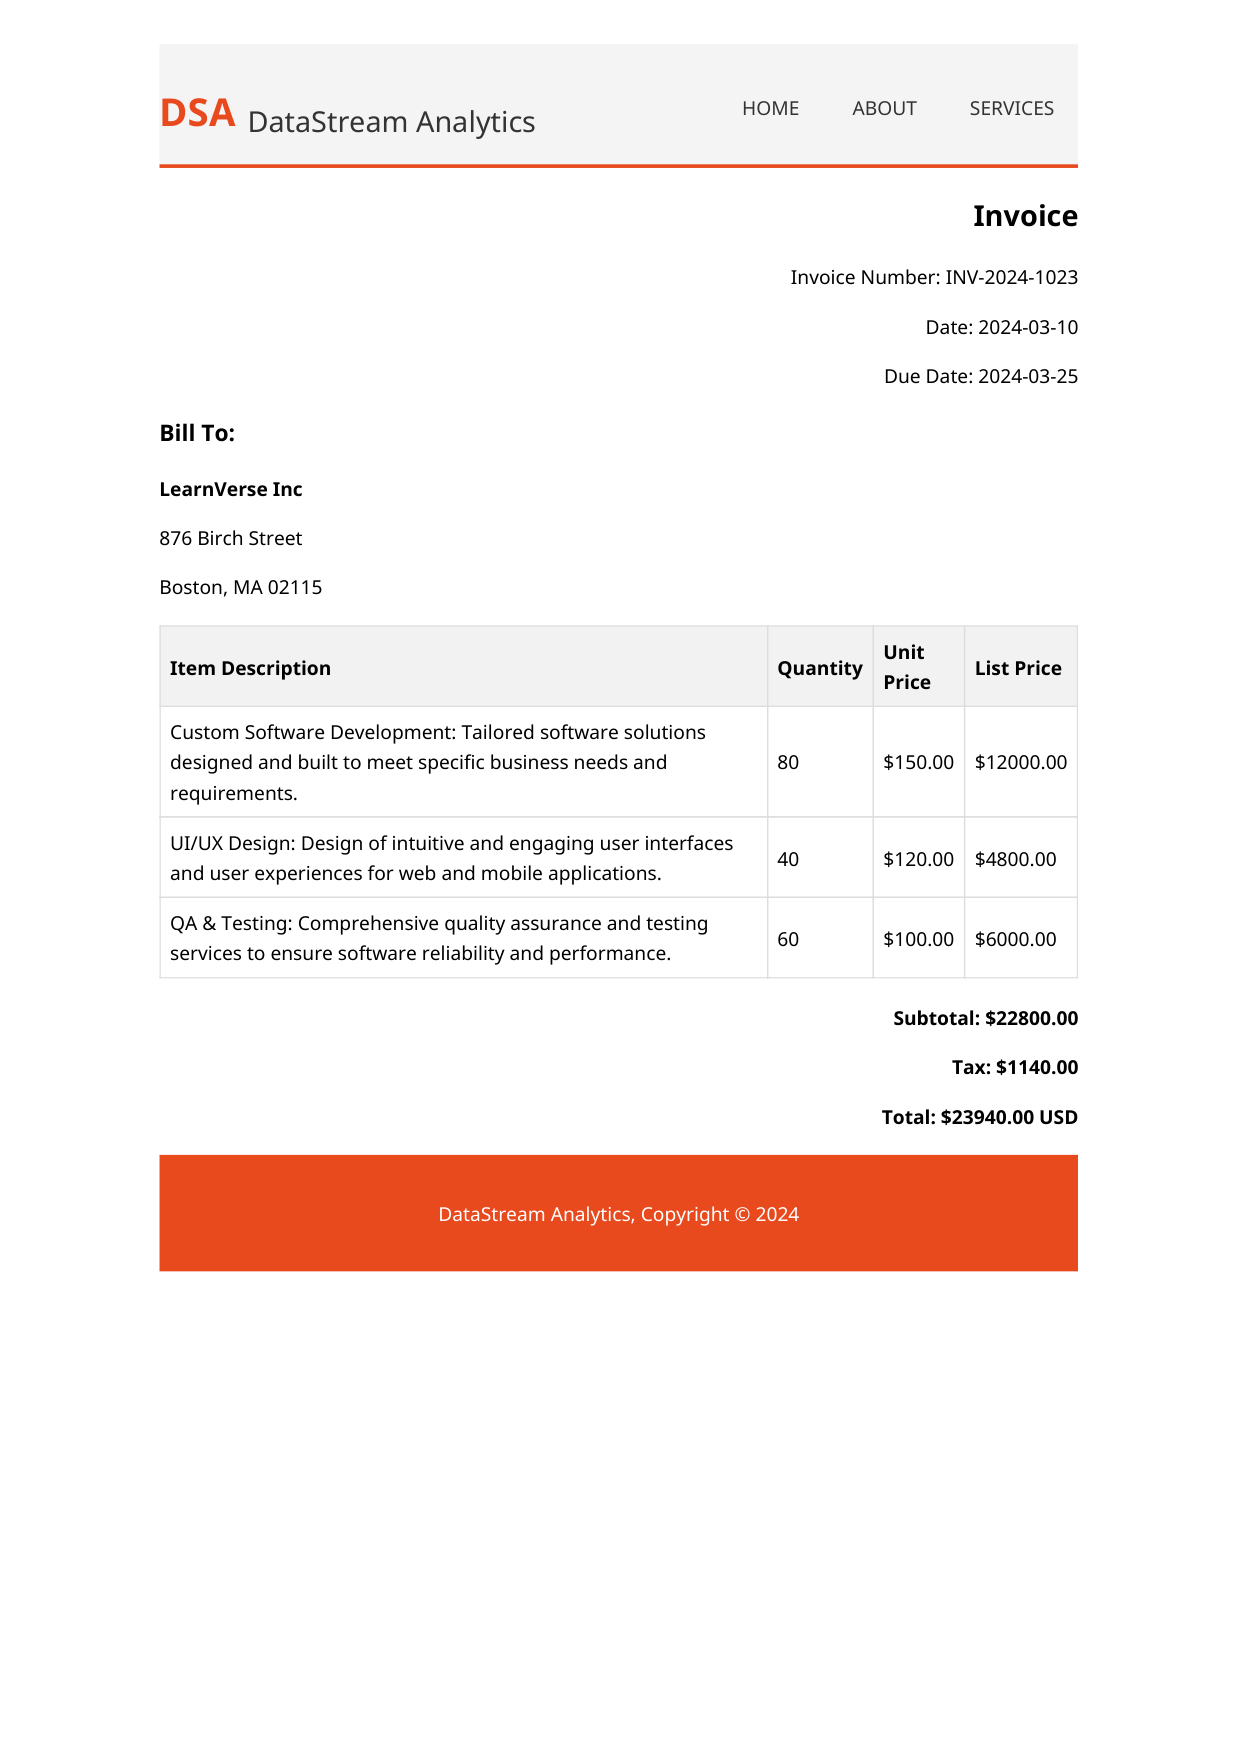

In [267]:
display(Image('./resources/documents/datastream_analytics/invoices/0.png', width=550))

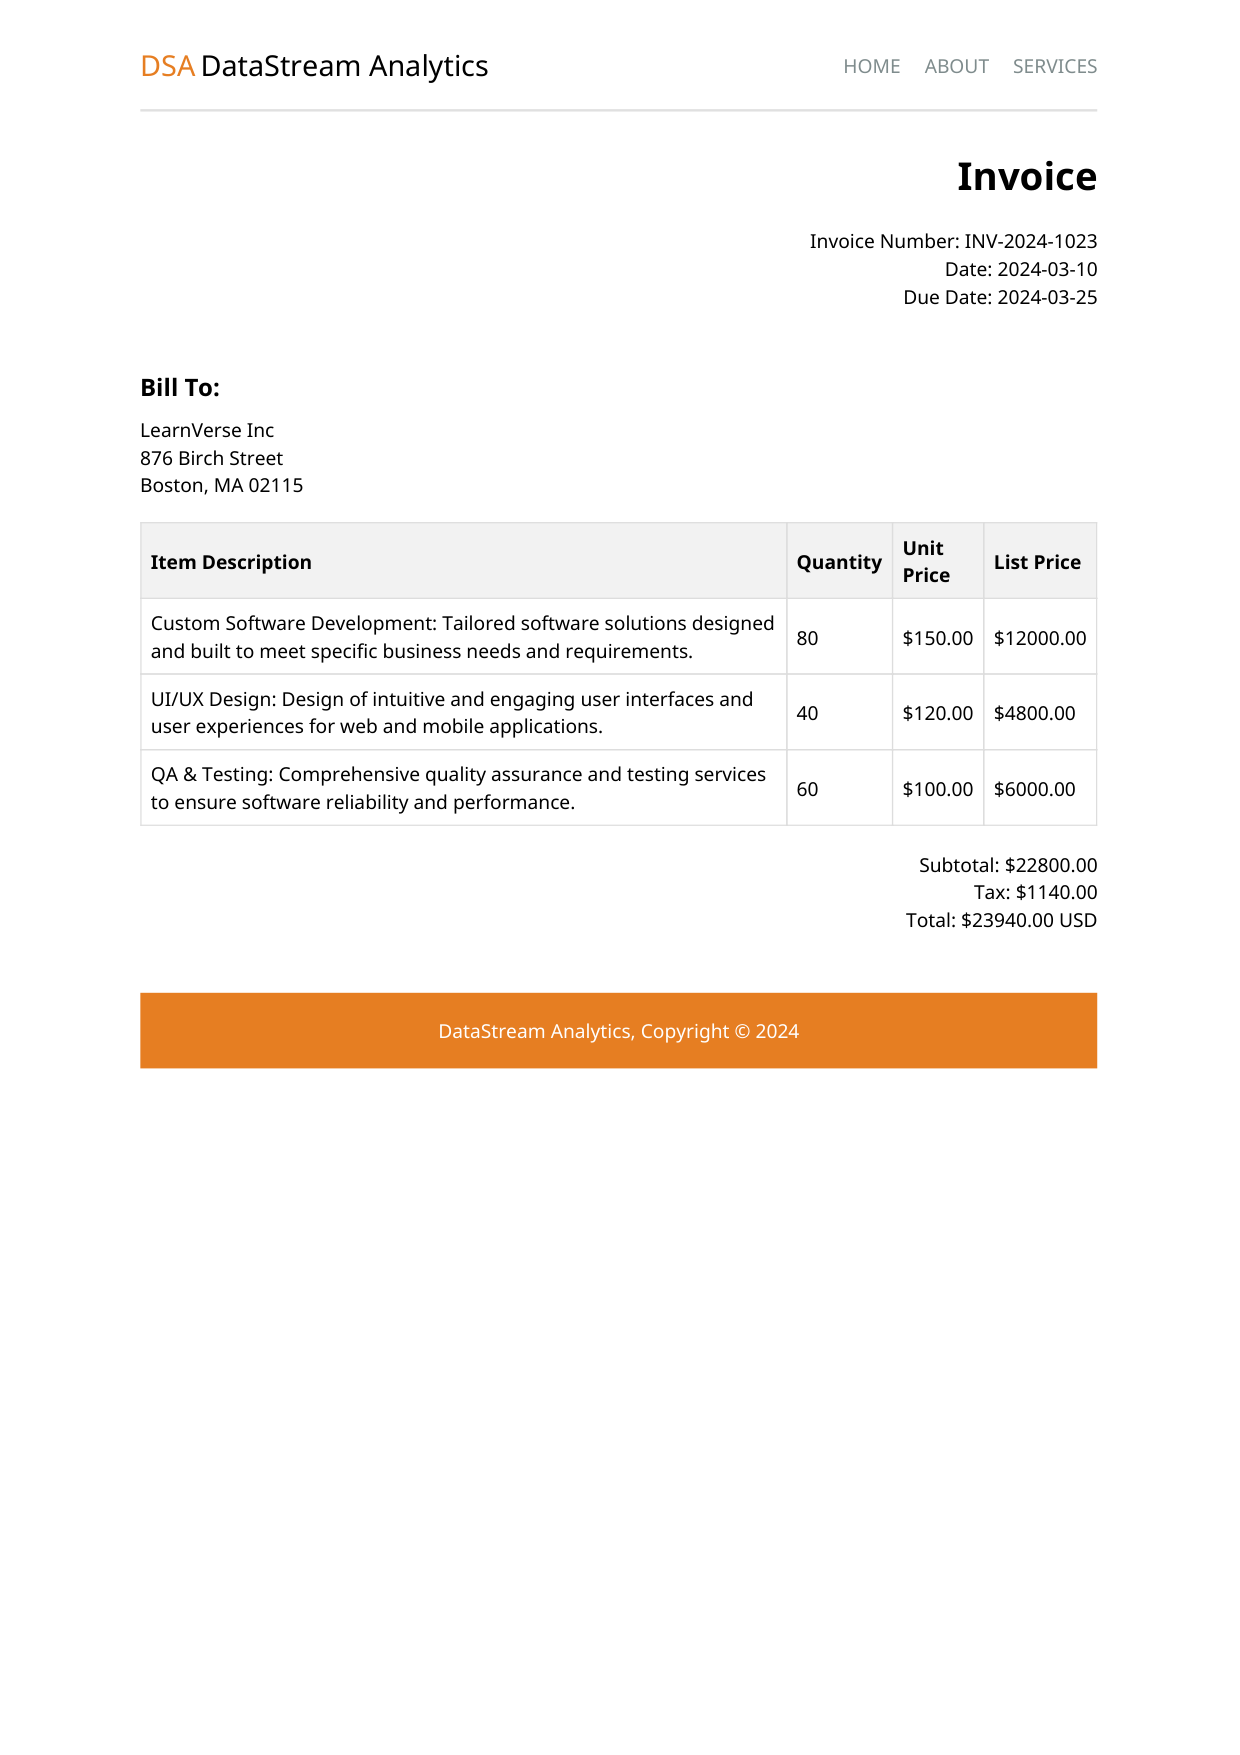

In [268]:
display(Image('./resources/documents/datastream_analytics/fake_invoices/0.png', width=550))

---
## Tried Multimodal Responses


In [ ]:
prompt = f"""
Generate a realistic, fictitious invoice based on the following details:

**Invoice:**
```json
{json.dumps(invoices[0], indent=2)}
```

**Instructions:**
1. Create html for an invoice with typical but unique layout
2. Select from the information provided
3. Don't add information
4. It is ok to leave information off that is not part of the invoice layout
5. Make the layout specific to the vendor including the creation of a simple plain logo and/or layout format
6. Feel free to use color for logos, headers, footers but it must remain formal for a business
"""

In [ ]:
#import base64

# imports for REST instead of Client Usage (genai)
#import requests
#import google.auth
#import google.auth.transport.requests

In [ ]:
# response = client.models.generate_content(
#     model = 'gemini-2.0-flash-exp',
#     contents = prompt,
#     config = genai.types.GenerateContentConfig(
#         temperature = 1,
#         response_modalities = ['IMAGE']
#     )
# )

In [ ]:
def generate_image(prompt):
  credentials, project_id_from_auth = google.auth.default(scopes=['https://www.googleapis.com/auth/cloud-platform'])
  auth_req = google.auth.transport.requests.Request()
  credentials.refresh(auth_req)
  access_token = credentials.token

  rest_url = f"https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.0-flash-exp:generateContent"

  headers = {
      # Use the obtained access token
      "Authorization": f"Bearer {access_token}",
      "Content-Type": "application/json; charset=utf-8",
  }

  rest_payload = {
    "contents": [
      {
        "role": "user",
        "parts": [{"text": prompt}]
      }
    ],
    "generation_config": {
      "temperature": 1.0,
      "response_modalities": ["IMAGE", "TEXT"]
    }
  }

  try:
    response = requests.post(
        rest_url,
        headers=headers,
        json=rest_payload
    )
    response.raise_for_status()
    response_data = response.json()
  except requests.exceptions.RequestException as e:
    if e.response is not None:
      print(f"Status Code: {e.response.status_code}")
      try:
        print("Response Body:\n", json.dumps(e.response.json(), indent=2))
      except json.JSONDecodeError:
        print("Response Body:\n", e.response.text)
  except Exception as e:
    print('Unexpected Error: ', e)

  return response_data


In [ ]:
response_data = generate_image(prompt)

In [ ]:
response_data

{'candidates': [{'content': {'role': 'model',
    'parts': [{'inlineData': {'mimeType': 'image/png',
       'data': 'iVBORw0KGgoAAAANSUhEUgAAAtkAAAQACAIAAAC7ztIUAAAAiXpUWHRSYXcgcHJvZmlsZSB0eXBlIGlwdGMAAAiZTYwxDgIxDAT7vOKekDjrtV1T0VHwgbtcIiEhgfh/QaDgmGlWW0w6X66n5fl6jNu9p+ULkapDENgzpj+Kl5aFfa6KnYWgSjZjGOiSYRxTY/v8KIijI/rXyc236kHdAK22RvHVummEN+91ML0BQ+siou79WmMAAAKHaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjUuMCI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiIHhtbG5zOklwdGM0eG1wRXh0PSJodHRwOi8vaXB0Yy5vcmcvc3RkL0lwdGM0eG1wRXh0LzIwMDgtMDItMjkvIiB4bWxuczpwaG90b3Nob3A9Imh0dHA6Ly9ucy5hZG9iZS5jb20vcGhvdG9zaG9wLzEuMC8iIElwdGM0eG1wRXh0OkRpZ2l0YWxTb3VyY2VGaWxlVHlwZT0iaHR0cDovL2N2LmlwdGMub3JnL25ld3Njb2Rlcy9kaWdpdGFsc291cmNldHlwZS90cmFpbmVkQWxnb3JpdGhtaWNNZWRpYSIgSXB0YzR4bXBFeHQ6RGl

In [ ]:
response_data.get('candidates')[0].get('content').get('parts')[0].get('inlineData')

{'mimeType': 'image/png',
 'data': 'iVBORw0KGgoAAAANSUhEUgAAAtkAAAQACAIAAAC7ztIUAAAAiXpUWHRSYXcgcHJvZmlsZSB0eXBlIGlwdGMAAAiZTYwxDgIxDAT7vOKekDjrtV1T0VHwgbtcIiEhgfh/QaDgmGlWW0w6X66n5fl6jNu9p+ULkapDENgzpj+Kl5aFfa6KnYWgSjZjGOiSYRxTY/v8KIijI/rXyc236kHdAK22RvHVummEN+91ML0BQ+siou79WmMAAAKHaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjUuMCI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiIHhtbG5zOklwdGM0eG1wRXh0PSJodHRwOi8vaXB0Yy5vcmcvc3RkL0lwdGM0eG1wRXh0LzIwMDgtMDItMjkvIiB4bWxuczpwaG90b3Nob3A9Imh0dHA6Ly9ucy5hZG9iZS5jb20vcGhvdG9zaG9wLzEuMC8iIElwdGM0eG1wRXh0OkRpZ2l0YWxTb3VyY2VGaWxlVHlwZT0iaHR0cDovL2N2LmlwdGMub3JnL25ld3Njb2Rlcy9kaWdpdGFsc291cmNldHlwZS90cmFpbmVkQWxnb3JpdGhtaWNNZWRpYSIgSXB0YzR4bXBFeHQ6RGlnaXRhbFNvdXJjZVR5cGU9Imh0dHA6Ly9jdi5pcHRjLm9yZy9uZXdzY29kZXMvZGlnaXRhbHNvdXJjZXR5

In [ ]:
def extract_decode(response_data):

    inline_data = None

    # extract
    try:
        # Navigate through the response structure using .get() for safety
        candidates = response_data.get('candidates', [])
        if not candidates:
            print("Warning: 'candidates' key not found or empty in the response data.")
            return None

        parts = candidates[0].get('content', {}).get('parts', [])
        if not parts:
            print("Warning: 'parts' key not found or empty in the first candidate's content.")
            return None

        inline_data = parts[0].get('inlineData')
        if inline_data is None:
            print("Warning: 'inlineData' key not found in the first part.")
            return None # Explicitly return None if not found

    except AttributeError as e:
        print(f"Error accessing nested data, check response structure: {e}")
        return None # Return None on unexpected structure
    except IndexError as e:
        print(f"Error accessing list elements (candidates/parts may be empty): {e}")
        return None # Return None if lists are empty/index out of bounds
    except Exception as e:
        # Catch any other unexpected errors during extraction
        print(f"An unexpected error occurred during data extraction: {e}")
        return None

    # decode
    if isinstance(inline_data, dict) and 'data' in inline_data:
        base64_data = inline_data.get('data')
        mime_type = inline_data.get('mimeType', 'unknown') # Optional: log mime type

        if not base64_data:
             print(f"Error: Found inlineData structure, but 'data' field is empty or missing.")
             return None

        try:
            # Decode the base64 string into image bytes
            image_bytes = base64.b64decode(base64_data)
            print(f"Successfully decoded image data ({mime_type}).") # You can remove this print if desired
            return image_bytes  # <<< Return the bytes on success

        except (base64.binascii.Error, ValueError) as e:
            # Handle potential errors during base64 decoding
            print(f"Error decoding base64 data: {e}")
            return None  # <<< Return None on decoding error
        except Exception as e:
            # Handle other potential errors during decoding
            print(f"An unexpected error occurred during decoding: {e}")
            return None # <<< Return None on other errors

    else:
        # Handle cases where inline_data wasn't a dict or lacked the 'data' key
        print("Error: 'inlineData' was found but is not a dictionary or lacks the 'data' key.")
        print(f"Value of inline_data: {inline_data}")
        return None # <<< Return None if structure is wrong

Successfully decoded image data (image/png).


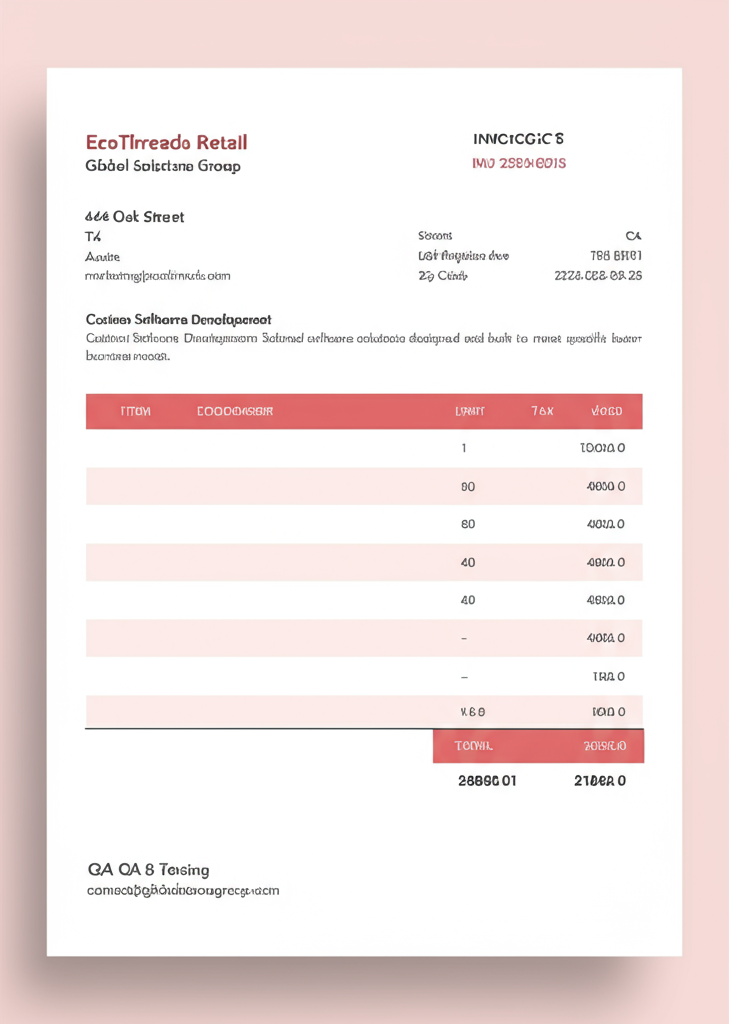

In [ ]:
display(Image(extract_decode(response_data)))